#### library

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error

#### data load

In [2]:
# file load

# train & test & submission load
data_path = "~/data"
train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# plus_info load
interest_data = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
park_data = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))
school_data = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
subway_data = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))

##### train & test

x 변수(10개)
1. index: 인덱스 번호  
2. area_m2: 면적 (제곱미터)  
3. contract_year_month: 계약년월  
4. contract_day: 계약일  
5. contract_type: 계약 유형(0: 신규, 1:갱신, 2:모름)  
6. floor: 층수  
7. built_year: 건축 연도  
8. latitude: 위도  
9. longitude: 경도  
10. age: 건물의 나이 (계산된 값)

y 변수(target)  
deposit: 전세 실거래가 (타겟 변수)

In [3]:
print(train_data.shape, test_data.shape)
train_data.head(3)

(1801228, 11) (150172, 10)


,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801228 entries, 0 to 1801227
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   area_m2              float64
 2   contract_year_month  int64  
 3   contract_day         int64  
 4   contract_type        int64  
 5   floor                int64  
 6   built_year           int64  
 7   latitude             float64
 8   longitude            float64
 9   age                  int64  
 10  deposit              float64
dtypes: float64(4), int64(7)
memory usage: 151.2 MB


In [5]:
train_data.isnull().sum()

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
dtype: int64

In [6]:
pd.DataFrame(train_data.nunique().values.reshape(-1,1), index = train_data.columns, columns = ['각 변수들의 고유값'])

,각 변수들의 고유값
index,1801228
area_m2,22281
contract_year_month,57
contract_day,31
contract_type,3
floor,73
built_year,61
latitude,18436
longitude,18447
age,66


##### other

In [7]:
# interest
print(interest_data.shape)
interest_data.head(3)

(66, 2)


,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59


In [8]:
# subway
print(park_data.shape)
park_data.head(3)

(17564, 3)


,latitude,longitude,area
0,37.509628,127.628406,856.0
1,37.508443,127.627414,847.0
2,37.493844,127.509326,1276.0


In [9]:
# school
print(school_data.shape)
school_data.head(3)

(11992, 3)


,schoolLevel,latitude,longitude
0,elementary,37.703889,127.540156
1,elementary,37.676874,127.600664
2,elementary,36.987340,129.399471


In [10]:
# subway
print(subway_data.shape)
subway_data.head(3)

(700, 2)


,latitude,longitude
0,37.759380,127.042292
1,37.541021,126.971300
2,37.529849,126.964561


#### EDA

target

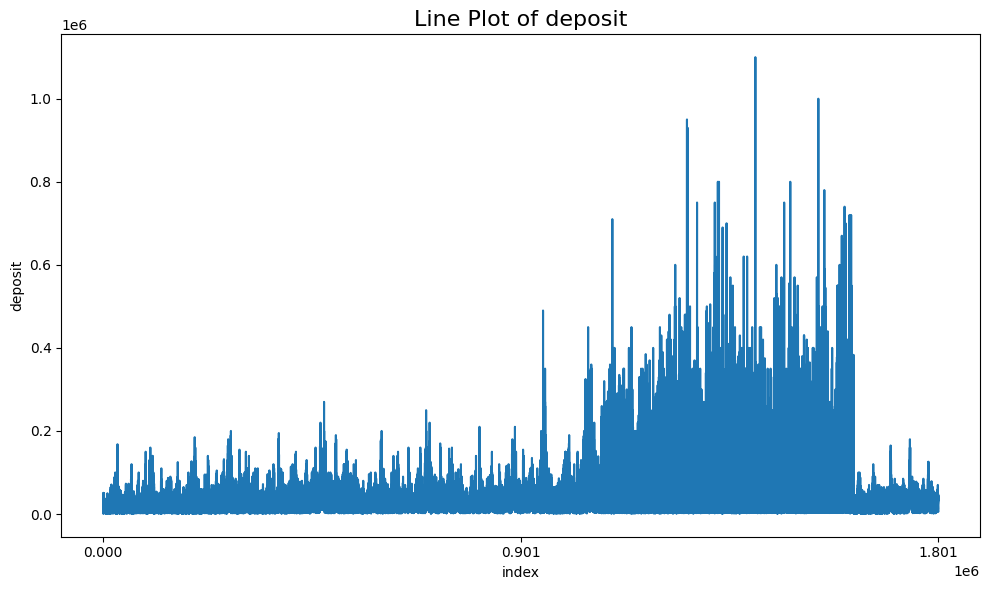

In [33]:
# deposit(전세 실거래가)에 대한 line graph

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_data, x='index', y='deposit')
plt.xlabel('index')
plt.title(f'Line Plot of deposit', fontsize=16)

# x축에 첨과 끝, 중간 레이블만 표시

first = train_data['index'][0]
middle = train_data['index'][len(train_data) // 2]
last = train_data['index'][len(train_data)-1]

xticks = [first, middle, last]
plt.xticks(xticks)
plt.tight_layout()
plt.show()

점차 deposit 값 즉, 전세가격이 올라가는 추세라고 말할 수 있다.(하지만 막판에 확 내려간 이유는 정확히 모르겠음..)

continous data

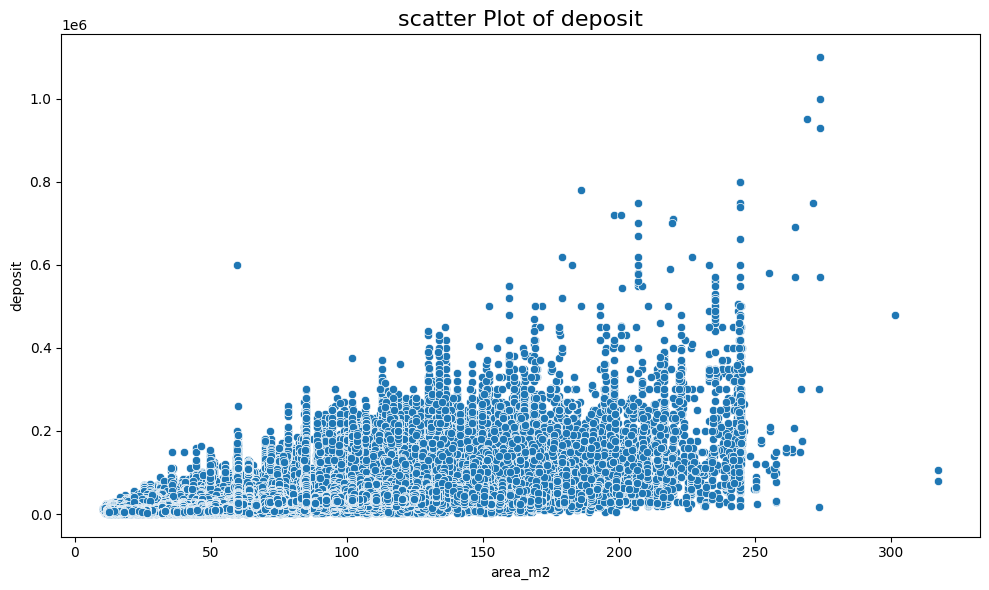

In [34]:
# deposit(전세 실거래가)에 대한 line graph

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='area_m2', y='deposit')
plt.xlabel('area_m2')
plt.ylabel('deposit')
plt.title(f'scatter Plot of deposit', fontsize=16)

plt.tight_layout()
plt.show()

아무래도 면적이 높을수록 전세가가 오르긴 함

year

In [11]:
# 계약연월 따로 추출
train_data['contract_year'] = pd.to_datetime(train_data['contract_year_month'].astype(str), format='%Y%m').dt.year
train_data['contract_month'] = pd.to_datetime(train_data['contract_year_month'].astype(str), format='%Y%m').dt.month

In [12]:
train_data.head(3)

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_year,contract_month
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,2019,6
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,2020,3
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,2020,3


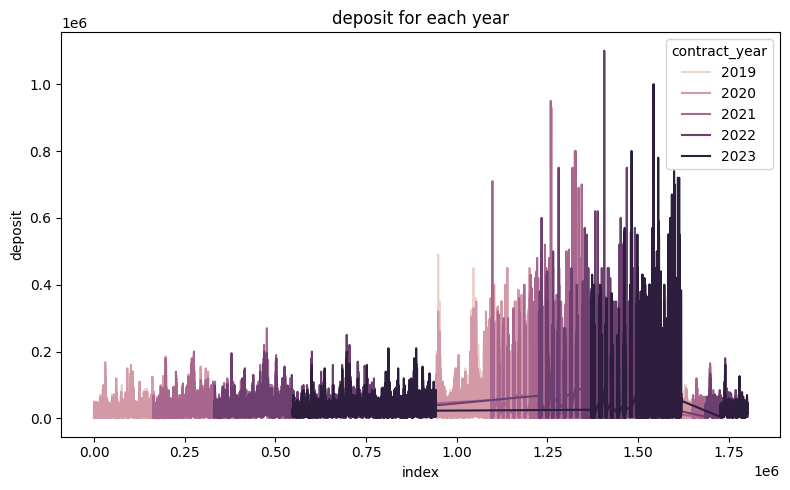

In [59]:
fig, ax1 = plt.subplots(1,1, figsize=(8,5))

sns.lineplot(data = train_data, x = 'index', y = 'deposit', hue = 'contract_year', ax = ax1)
ax1.set(ylabel = 'deposit', title = 'deposit for each year')

plt.tight_layout()
plt.show()

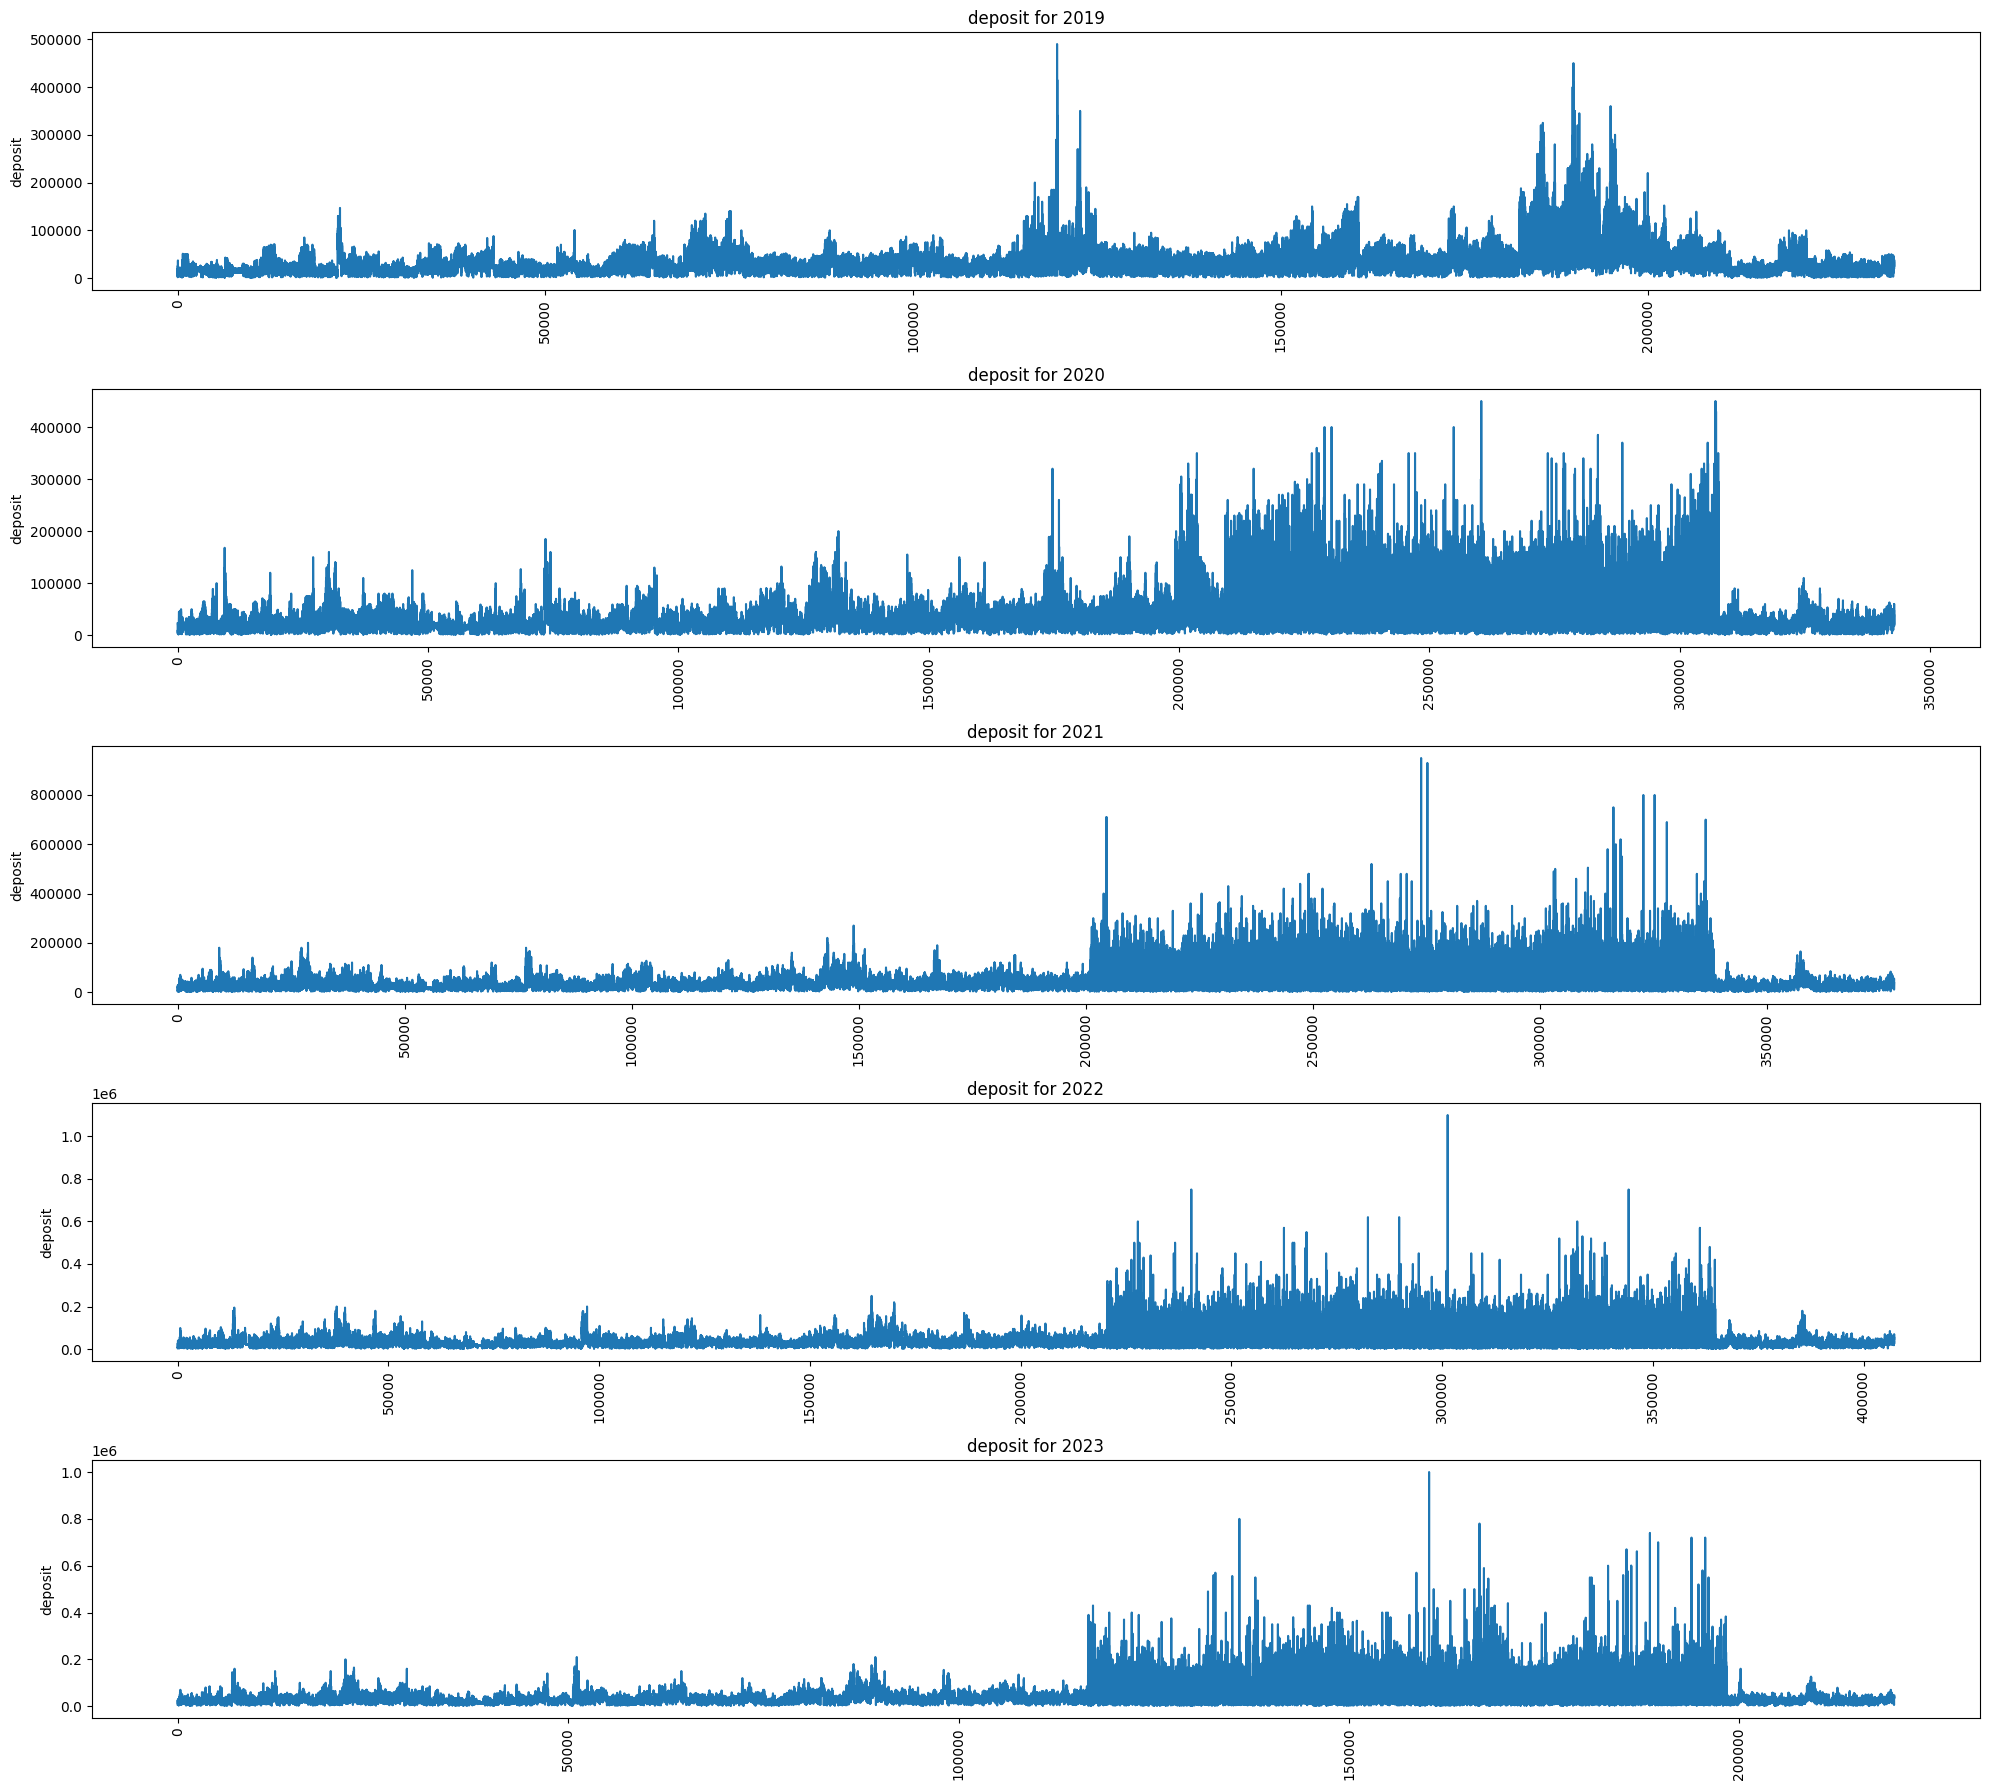

In [76]:
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(5,1, figsize=(20,18))

sns.lineplot(data = train_data[train_data['contract_year'] == 2019], x = range(len(train_data[train_data['contract_year'] == 2019])), y = 'deposit', ax = ax1)
sns.lineplot(data = train_data[train_data['contract_year'] == 2020], x = range(len(train_data[train_data['contract_year'] == 2020])), y = 'deposit', ax = ax2)
sns.lineplot(data = train_data[train_data['contract_year'] == 2021], x = range(len(train_data[train_data['contract_year'] == 2021])), y = 'deposit', ax = ax3)
sns.lineplot(data = train_data[train_data['contract_year'] == 2022], x = range(len(train_data[train_data['contract_year'] == 2022])), y = 'deposit', ax = ax4)
sns.lineplot(data = train_data[train_data['contract_year'] == 2023], x = range(len(train_data[train_data['contract_year'] == 2023])), y = 'deposit', ax = ax5)

ax1.set(ylabel = 'deposit', title = 'deposit for 2019')
ax2.set(ylabel = 'deposit', title = 'deposit for 2020')
ax3.set(ylabel = 'deposit', title = 'deposit for 2021')
ax4.set(ylabel = 'deposit', title = 'deposit for 2022')
ax5.set(ylabel = 'deposit', title = 'deposit for 2023')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 90)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 90)
ax5.set_xticklabels(ax4.get_xticklabels(), rotation = 90)


plt.tight_layout()
plt.show()

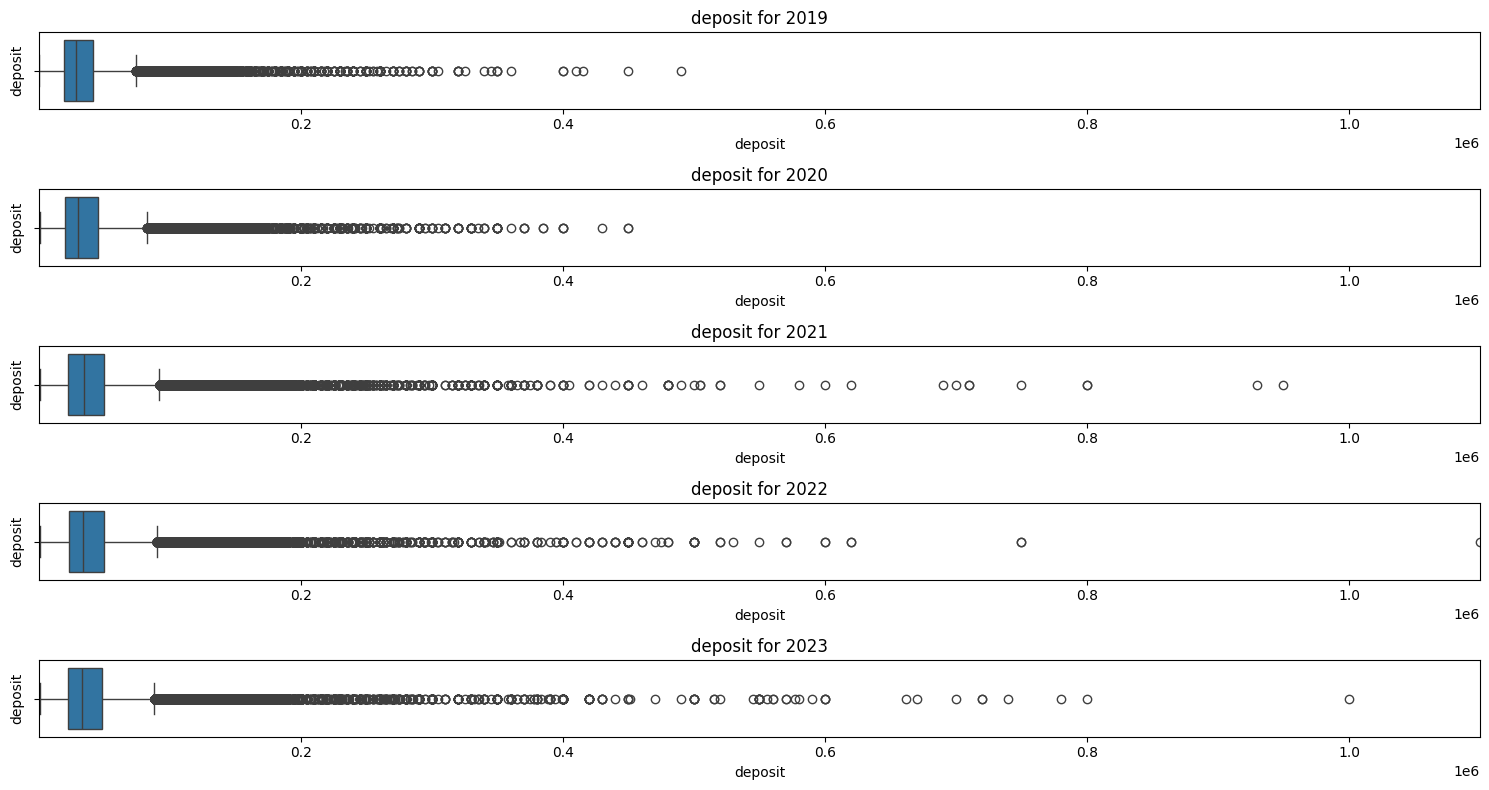

In [20]:
deposit_min = train_data['deposit'].min()
deposit_max = train_data['deposit'].max()

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(5,1, figsize=(15,8))

sns.boxplot(data = train_data[train_data['contract_year'] == 2019], x = 'deposit', ax = ax1)
sns.boxplot(data = train_data[train_data['contract_year'] == 2020],  x = 'deposit', ax = ax2)
sns.boxplot(data = train_data[train_data['contract_year'] == 2021],  x = 'deposit', ax = ax3)
sns.boxplot(data = train_data[train_data['contract_year'] == 2022],  x = 'deposit', ax = ax4)
sns.boxplot(data = train_data[train_data['contract_year'] == 2023], x = 'deposit', ax = ax5)

ax1.set(ylabel = 'deposit', title = 'deposit for 2019')
ax2.set(ylabel = 'deposit', title = 'deposit for 2020')
ax3.set(ylabel = 'deposit', title = 'deposit for 2021')
ax4.set(ylabel = 'deposit', title = 'deposit for 2022')
ax5.set(ylabel = 'deposit', title = 'deposit for 2023')

ax1.set_xlim(deposit_min, deposit_max)
ax2.set_xlim(deposit_min, deposit_max)
ax3.set_xlim(deposit_min, deposit_max)
ax4.set_xlim(deposit_min, deposit_max)
ax5.set_xlim(deposit_min, deposit_max)

plt.tight_layout()
plt.show()

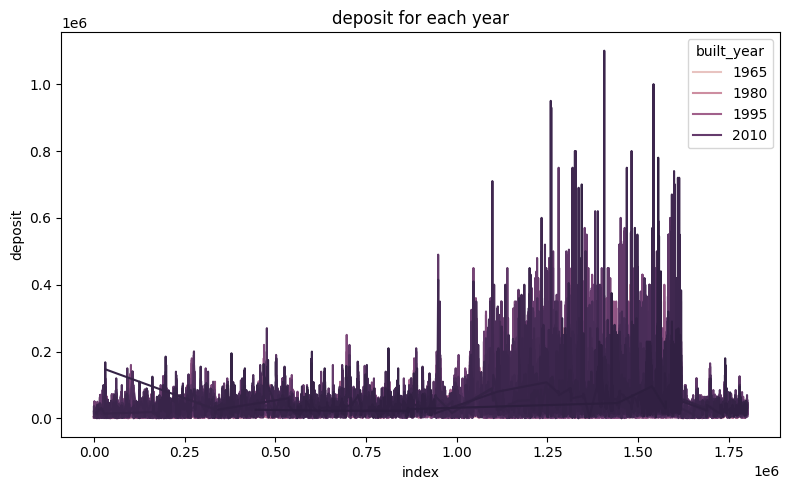

In [24]:
### built year
fig, ax1 = plt.subplots(1,1, figsize=(8,5))

sns.lineplot(data = train_data, x = 'index', y = 'deposit', hue = 'built_year', ax = ax1)
ax1.set(ylabel = 'deposit', title = 'deposit for each year')

plt.tight_layout()
plt.show()

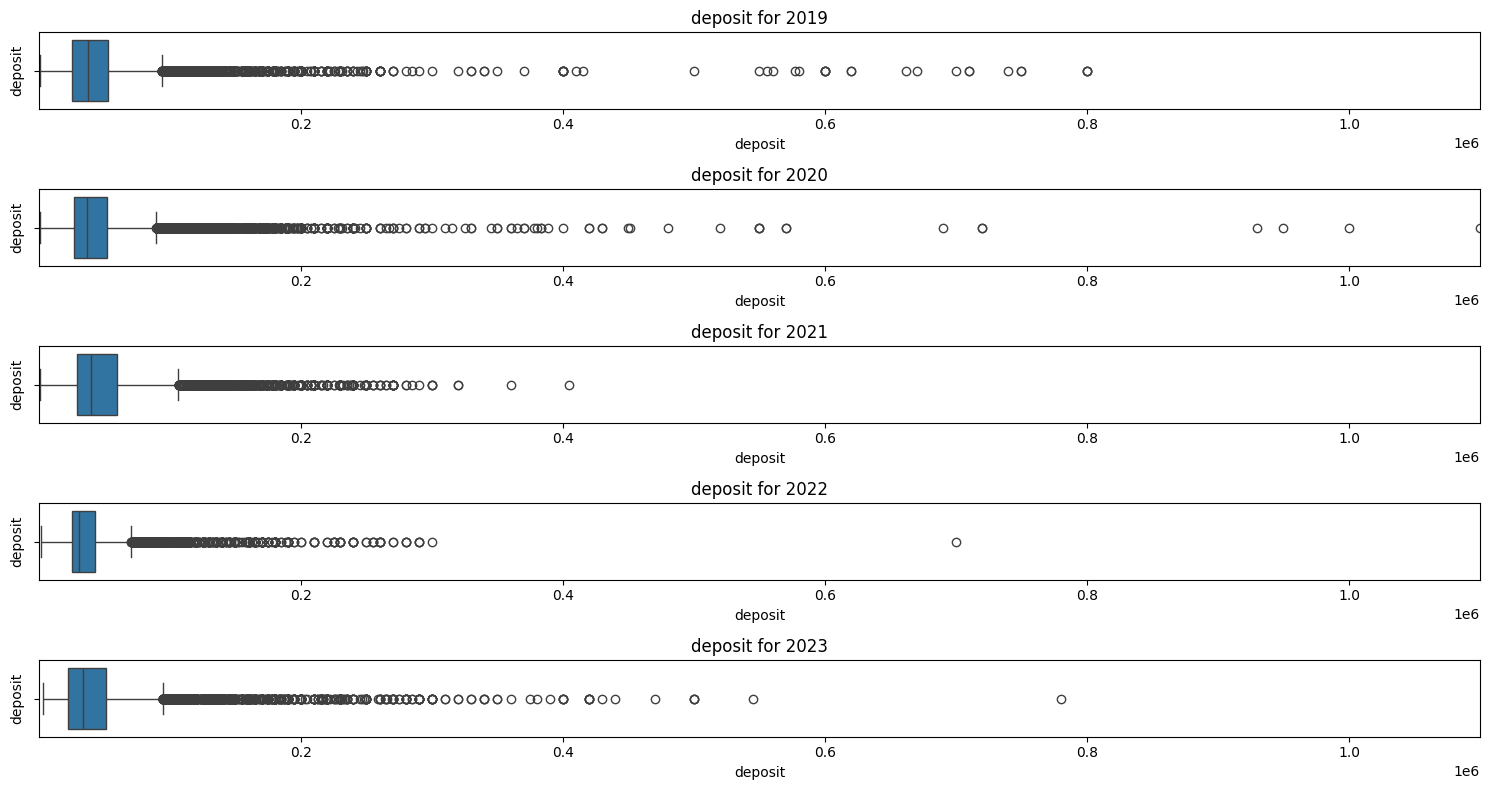

In [25]:
deposit_min = train_data['deposit'].min()
deposit_max = train_data['deposit'].max()

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(5,1, figsize=(15,8))

sns.boxplot(data = train_data[train_data['built_year'] == 2019], x = 'deposit', ax = ax1)
sns.boxplot(data = train_data[train_data['built_year'] == 2020],  x = 'deposit', ax = ax2)
sns.boxplot(data = train_data[train_data['built_year'] == 2021],  x = 'deposit', ax = ax3)
sns.boxplot(data = train_data[train_data['built_year'] == 2022],  x = 'deposit', ax = ax4)
sns.boxplot(data = train_data[train_data['built_year'] == 2023], x = 'deposit', ax = ax5)

ax1.set(ylabel = 'deposit', title = 'deposit for 2019')
ax2.set(ylabel = 'deposit', title = 'deposit for 2020')
ax3.set(ylabel = 'deposit', title = 'deposit for 2021')
ax4.set(ylabel = 'deposit', title = 'deposit for 2022')
ax5.set(ylabel = 'deposit', title = 'deposit for 2023')

ax1.set_xlim(deposit_min, deposit_max)
ax2.set_xlim(deposit_min, deposit_max)
ax3.set_xlim(deposit_min, deposit_max)
ax4.set_xlim(deposit_min, deposit_max)
ax5.set_xlim(deposit_min, deposit_max)

plt.tight_layout()
plt.show()

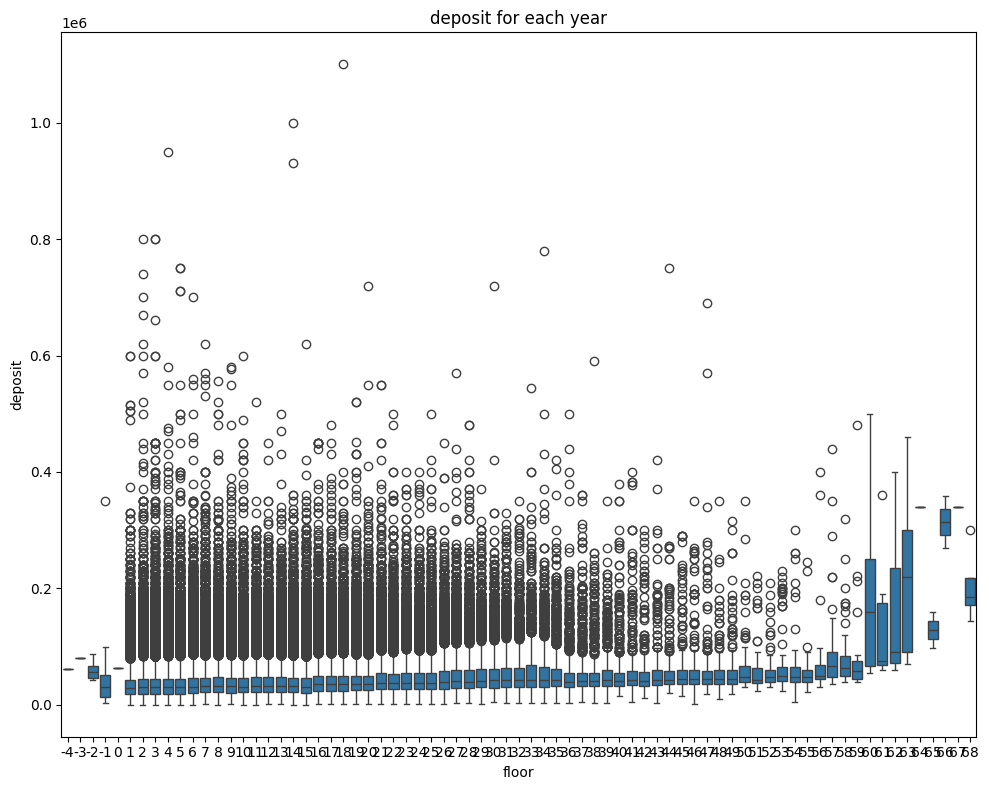

In [27]:
# floor
### built year
fig, ax1 = plt.subplots(1,1, figsize=(10,8))

sns.boxplot(data = train_data, x = 'floor', y = 'deposit')
ax1.set(ylabel = 'deposit', title = 'deposit for each year')

plt.tight_layout()
plt.show()

#### feature engineering

other과 연계된 column 구성

In [22]:
train_data[['latitude','longitude']]

,latitude,longitude
0,37.054314,127.045216
1,37.054314,127.045216
2,37.054314,127.045216
3,36.964647,127.055847
4,36.972390,127.084514
...,...,...
1801223,37.528394,126.659398
1801224,37.528394,126.659398
1801225,37.528394,126.659398
1801226,37.528394,126.659398
